In [1]:
# Jupyter notebook to compare DECaLS magnitudes and SDSS magnitudes

# Last edited 27 July 2017 at 4:32pm

In [40]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pylab as plt 
import matplotlib.lines as mlines
from matplotlib.legend import Legend
from pythonds.basic.stack import Stack
import pandas as pd

In [41]:
# Read in data
hdulist = fits.open('http://portal.nersc.gov/project/cosmo/data/legacysurvey/dr3/external/survey-dr3-specObj-dr13.fits')
hdulist2 = fits.open('https://data.sdss.org/sas/dr13/sdss/spectro/redux/specObj-dr13.fits')
tbdata = hdulist[1].data
tbdata2 = hdulist2[1].data

# Put data in arrays

# Object ID from survey file; value -1 for non-matches
objid = []
objid = tbdata.field('OBJID') 

# Only galaxies included
gal_type = []
gal_type = tbdata.field('TYPE') 

# Don't need this because we need all sources
# What survey the data comes from
survey = []
survey = tbdata2.field('SURVEY')

# RA
ra = []
ramatch = []
ra = tbdata.field('RA')

# Dec
dec = []
decmatch = []
dec = tbdata.field('DEC')

# Galaxy class
gal_class = []
gal_class = tbdata2.field('CLASS') 

# SPECPRIMARY; set to 1 for primary observation of object, 0 otherwise
spec = []
spec = tbdata2.field('SPECPRIMARY')

# Bitmask of spectroscopic warning values; need set to 0
zwarn_noqso = []
zwarn_noqso = tbdata2.field('ZWARNING_NOQSO')

# Spectroscopic classification for certain redshift?
class_noqso = []
class_noqso = tbdata2.field('CLASS_NOQSO')

# Array for LOWZ targets
targets = []
target_match = []
targets = tbdata2.field('BOSS_TARGET1')
targetVec = np.array(targets)

# Section of code to find LOWZ targets

# Function to find LOWZ targets
def divideBy2(decNumber):
	np.vectorize(decNumber)
	remstack = Stack()
	
	if decNumber == 0: return "0"
	
	while decNumber > 0:
		rem = decNumber % 2
		remstack.push(rem)
		decNumber = decNumber // 2
		
	binString = ""
	while not remstack.isEmpty():
		binString = binString + str(remstack.pop())
			
	return binString

divideBy2Vec = np.vectorize(divideBy2)

a = divideBy2Vec(targets) # gives binary in string form
bin2int = [int(i) for i in a] # converts binary strings to integer
tar = np.array(bin2int) # puts list of integers into numpy array
c = tar % 2 # divide by two again to see if the binary number ends in zero
lowz_tar = np.array(c)

# Number of observations of source from legacy file
obs = []
obsmatch = []
obs = tbdata.field('DECAM_NOBS') 

# Put flux data in an array from legacy file
# Flux has ugrizY, so needs to be divided into 6 arrays
flux =[]
fluxmatch = []

# Flux from DECAM
flux = tbdata.field('DECAM_FLUX')

462
462


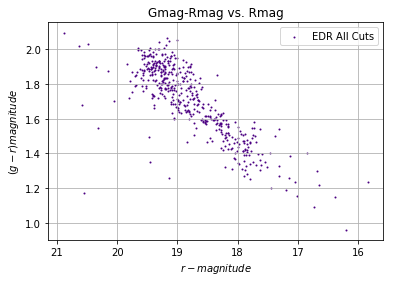

In [42]:
# In which I read in DECaLS model fluxes for only DECaLS EDR sources, calculate magnitudes, and make a CM plot

obsmatch = obs[np.where((lowz_tar == 1) & (ra >= 241) & (ra <= 246) & (dec >= 6.5) & (dec <= 11.5) & (objid > -1) & (gal_class == 'GALAXY') & (spec == 1 ) & (zwarn_noqso == 0) & (class_noqso == 'GALAXY') & ((survey == 'sdss') | (survey == 'boss')) & ((gal_type == 'DEV') | (gal_type == 'EXP') | (gal_type == 'COMP') | (gal_type == 'SIMP')))]

# Put number of observations per filter into arrays that match the filter
uobs = []
gobs = []
robs = []
iobs = []
zobs = []
yobs = []

b = np.array(obsmatch)
uobs = b[:,0]
gobs = b[:,1]
robs = b[:,2]
iobs = b[:,3]
zobs = b[:,4]
yobs = b[:,5]

fluxmatch = flux[np.where((lowz_tar == 1) & (ra >= 241) & (ra <= 246) & (dec >= 6.5) & (dec <= 11.5) & (objid > -1) & (gal_class == 'GALAXY') & (spec == 1 ) & (zwarn_noqso == 0) & (class_noqso == 'GALAXY') & ((survey == 'sdss') | (survey == 'boss')) & ((gal_type == 'DEV') | (gal_type == 'EXP') | (gal_type == 'COMP') | (gal_type == 'SIMP')))]

# Divide flux arrays into 6 arrays
uflux = []
gflux = []
rflux = []
iflux = []
zflux = []
yflux = []

a = np.array(fluxmatch)
uflux = a[:,0]
gflux = a[:,1]
rflux = a[:,2]
iflux = a[:,3]
zflux = a[:,4]
yflux = a[:,5]

# Finds flux that correspond with at least 3 observations and a flux > 0
gflux_match = gflux[np.where((gobs >= 3) & (robs >= 3) & (gflux > 0.) & (rflux > 0.))]
rflux_match = rflux[np.where((gobs >= 3) & (robs >= 3) & (rflux > 0.) & (gflux > 0.))]

# print(len(obsmatch))
# print(len(fluxmatch))

# Calculate gmag, rmag, and (g-r) color
gmag_edr = 22.5 - 2.5 * np.log10(gflux_match)
rmag_edr = 22.5 - 2.5 * np.log10(rflux_match)

print(len(gmag_edr))
print(len(rmag_edr))

color_edr = gmag_edr - rmag_edr

# Plot
plt.scatter(rmag_edr, color_edr, s = 1, color = 'indigo', label = 'EDR All Cuts')

plt.gca().invert_xaxis()

plt.grid(True)
plt.title('Gmag-Rmag vs. Rmag')
plt.xlabel(r'$r-magnitude$')
plt.ylabel(r'$(g-r) magnitude$')

plt.legend(loc='upper right')

plt.show()

460
460


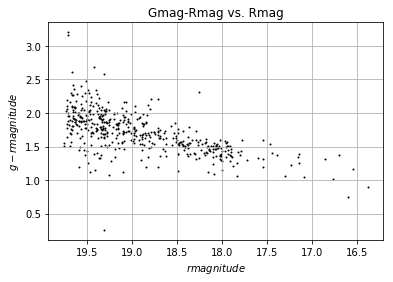

In [43]:
# In which I read in SDSS cModel fluxes from DR13 for only DECaLS EDR sources, caculate magnitudes and make a 
# CM plot.

flux = pd.read_csv("https://raw.githubusercontent.com/metownsend/Data/master/sdss_cmodel_coords_and_flux.csv", sep=',', header=0)

# Assign data to a variable

ident = flux['objid'].values
sdss_ra = flux['ra'].values
sdss_dec = flux['dec'].values
sdss_gflux = flux['gflux'].values
sdss_rflux = flux['rflux'].values

# print(len(sdss_gflux))
# print(len(sdss_rflux))

# Calculate magnitudes and color

sdss_gmag = 22.5 - 2.5 * np.log10(sdss_gflux[np.where((sdss_gflux > 0.) & (sdss_rflux > 0.))])
sdss_rmag = 22.5 - 2.5 * np.log10(sdss_rflux[np.where((sdss_gflux > 0.) & (sdss_rflux > 0.))])

print(len(sdss_gmag))
print(len(sdss_rmag))

sdss_color = sdss_gmag - sdss_rmag

# CM plot for all SDSS galaxies in DECaLS EDR

plt.scatter(sdss_rmag, sdss_color, s = 1, color = 'black')
plt.gca().invert_xaxis()

plt.grid(True)
plt.title('Gmag-Rmag vs. Rmag')
plt.xlabel(r'$r-magnitude$')
plt.ylabel(r'$(g-r) magnitude$')

plt.show()

In [44]:
# I'm pretty sure I've identified the sources that exist in DECaLS but not SDSS. I eliminate those two sources and
# compare the gmags and rmags from DECaLS and SDSS

In [55]:
# This section will eliminate the two sources from DECaLS mags 

# These are the indices in DECaLS to be eliminated
index = [0,75]

# Creating a new DECaLS mag array
new_decals_gmag = np.delete(gmag_edr, index)
new_decals_rmag = np.delete(gmag_edr, index)

# Creating a new DECaLS flux array
new_decals_gflux = np.delete(gflux_match, index)
new_decals_rflux = np.delete(rflux_match, index)

print(len(new_decals_gmag))
print(len(sdss_gmag))
print(len(new_decals_gflux))

460
460
460


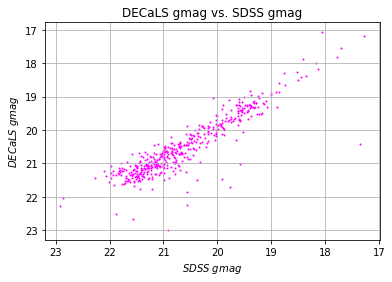

In [82]:
# Plots DECaLS gmag vs SDSS gmag

plt.scatter(sdss_gmag, new_decals_gmag, s = 1, color = 'magenta')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.grid(True)
plt.title('DECaLS gmag vs. SDSS gmag')
plt.xlabel(r'$SDSS$ $gmag$')
plt.ylabel(r'$DECaLS$ $gmag$')

plt.show()

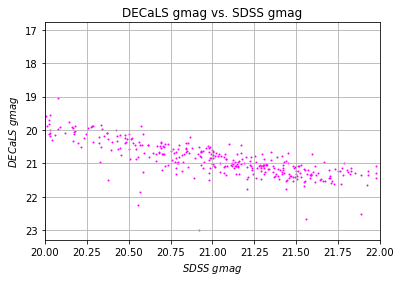

In [83]:
# Zoom in between 20 < SDSS gmag < 22

plt.scatter(sdss_gmag, new_decals_gmag, s = 1, color = 'magenta')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.xlim(20, 22)

plt.grid(True)
plt.title('DECaLS gmag vs. SDSS gmag')
plt.xlabel(r'$SDSS$ $gmag$')
plt.ylabel(r'$DECaLS$ $gmag$')

plt.show()

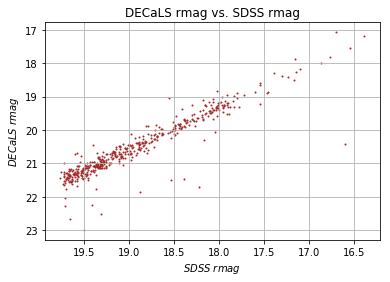

In [84]:
# Plots DECaLS rmag vs SDSS rmag

plt.scatter(sdss_rmag, new_decals_rmag, s = 1, color = 'brown')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.grid(True)
plt.title('DECaLS rmag vs. SDSS rmag')
plt.xlabel(r'$SDSS$ $rmag$')
plt.ylabel(r'$DECaLS$ $rmag$')

plt.show()

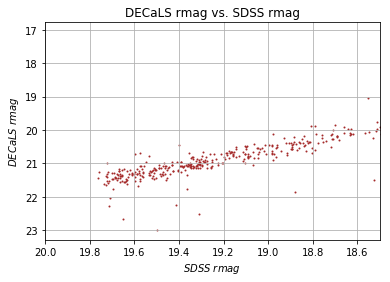

In [90]:
# Zoom in between 18.5 < SDSS rmag < 20

plt.scatter(sdss_rmag, new_decals_rmag, s = 1, color = 'brown')

plt.xlim(18.5, 20)

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.grid(True)
plt.title('DECaLS rmag vs. SDSS rmag')
plt.xlabel(r'$SDSS$ $rmag$')
plt.ylabel(r'$DECaLS$ $rmag$')

plt.show()

In [61]:
# So...there are offsets here. Some seem fairly significant?

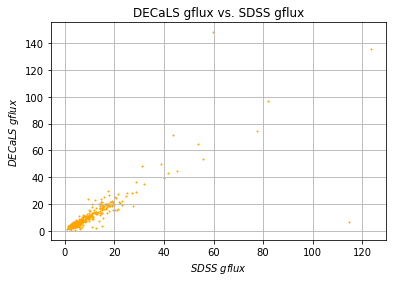

In [99]:
# Let me see where the the fluxes are at.

# Plots DECaLS gflux vs SDSS gflux

plt.scatter(sdss_gflux, new_decals_gflux, s = 1, color = 'orange')

plt.grid(True)
plt.title('DECaLS gflux vs. SDSS gflux')
plt.xlabel(r'$SDSS$ $gflux$')
plt.ylabel(r'$DECaLS$ $gflux$')

plt.show()

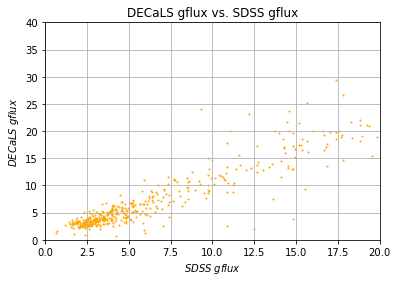

In [98]:
# Zoom in between 0 < SDSS gflux < 20

plt.scatter(sdss_gflux, new_decals_gflux, s = 1, color = 'orange')

plt.xlim(0, 20)
plt.ylim(0,40)

plt.grid(True)
plt.title('DECaLS gflux vs. SDSS gflux')
plt.xlabel(r'$SDSS$ $gflux$')
plt.ylabel(r'$DECaLS$ $gflux$')

plt.show()

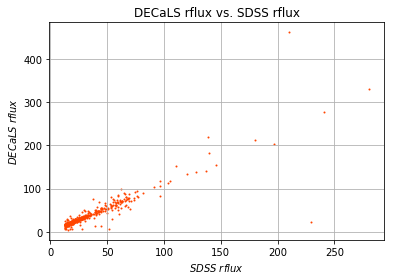

In [97]:
# Plots DECaLS rflux vs SDSS rflux

plt.scatter(sdss_rflux, new_decals_rflux, s = 1, color = 'orangered')

plt.grid(True)
plt.title('DECaLS rflux vs. SDSS rflux')
plt.xlabel(r'$SDSS$ $rflux$')
plt.ylabel(r'$DECaLS$ $rflux$')

plt.show()

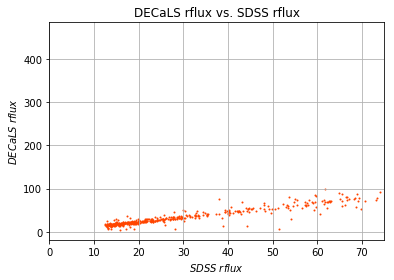

In [96]:
# Zoom in between 0 < SDSS rflux < 75

plt.scatter(sdss_rflux, new_decals_rflux, s = 1, color = 'orangered')

plt.xlim(0, 75)
# plt.ylim(0,100)

plt.grid(True)
plt.title('DECaLS rflux vs. SDSS rflux')
plt.xlabel(r'$SDSS$ $rflux$')
plt.ylabel(r'$DECaLS$ $rflux$')

plt.show()

In [66]:
# Let me find the differences between DECaLS gmag and rmag and SDSS gmag and rmag.

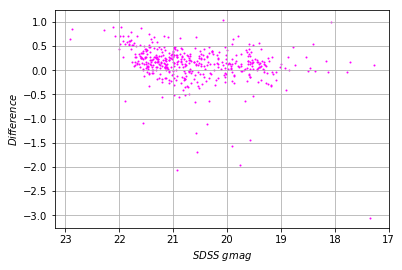

In [100]:
# Difference between DECaLS gmag and SDSS gmag with plot

diff = sdss_gmag - new_decals_gmag

plt.scatter(sdss_gmag, diff, s = 1, color = 'magenta')

plt.gca().invert_xaxis()

plt.grid(True)
# plt.title('DECaLS gflux vs. SDSS gflux')
plt.xlabel(r'$SDSS$ $gmag$')
plt.ylabel(r'$Difference$')

plt.show()

In [ ]:
# These are differences in g magnitudes The differences hover around zero, but it looks like magnitude in g is 
# generally higher in SDSS wrt DECaLS. 

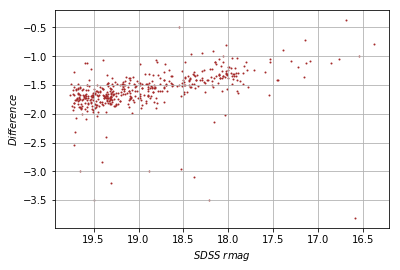

In [101]:
# Difference between DECaLS rmag and SDSS rmag with plot

diff = sdss_rmag - new_decals_rmag

plt.scatter(sdss_rmag, diff, s = 1, color = 'brown')

plt.gca().invert_xaxis()

plt.grid(True)
# plt.title('DECaLS gflux vs. SDSS gflux')
plt.xlabel(r'$SDSS$ $rmag$')
plt.ylabel(r'$Difference$')

plt.show()

In [71]:
# Oh but whoa it looks like the magnitude in r is always larger in DECaLS wrt SDSS.

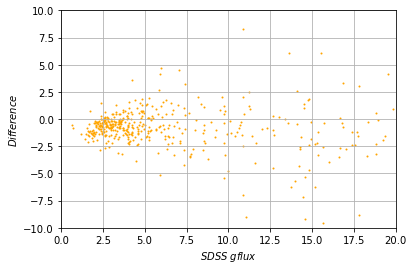

In [74]:
# Difference between DECaLS gflux and SDSS gflux with plot

diff = sdss_gflux - new_decals_gflux

plt.scatter(sdss_gflux, diff, s = 1, color = 'orange')

plt.xlim(0,20)
plt.ylim(-10,10)

plt.grid(True)
# plt.title('DECaLS gflux vs. SDSS gflux')
plt.xlabel(r'$SDSS$ $gflux$')
plt.ylabel(r'$Difference$')

plt.show()

In [75]:
# Ah well that makes sense given the difference in gmag plot. The plot indicates that DECaLS gflux values are larger
# that gflux values in SDSS.

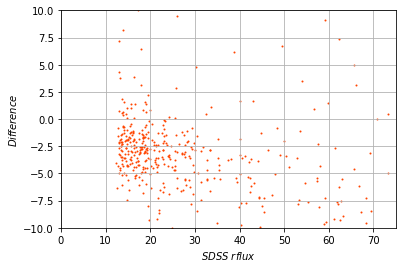

In [79]:
# Difference between DECaLS rflux and SDSS rflux with plot

diff = sdss_rflux - new_decals_rflux

plt.scatter(sdss_rflux, diff, s = 1, color = 'orangered')

plt.xlim(0,75)
plt.ylim(-10,10)

plt.grid(True)
# plt.title('DECaLS gflux vs. SDSS gflux')
plt.xlabel(r'$SDSS$ $rflux$')
plt.ylabel(r'$Difference$')

plt.show()

In [102]:
# OK but this...doesn't make sense to me. The difference in rmag plot indicates that DECaLS rmags are always greater
# than SDSS rmags. So I expected the rflux of SDSS to be higher than the rflux for DECaLS. Right? 

In [103]:
# I also downloaded the cModel magnitudes directly from SDSS. I plot those vs the DECaLS data below.

In [107]:
# In which I read in SDSS cModel magnitudes from DR13 for only DECaLS EDR sources

mag = pd.read_csv("https://raw.githubusercontent.com/metownsend/Data/master/sdss_cmodel_coords_mag.csv", sep=',', header=0)

# Assign data to a variable

ident = mag['objid'].values
sdss_ra = mag['ra'].values
sdss_dec = mag['dec'].values
cmodel_gmag = mag['gmag'].values
cmodel_rmag = mag['rmag'].values

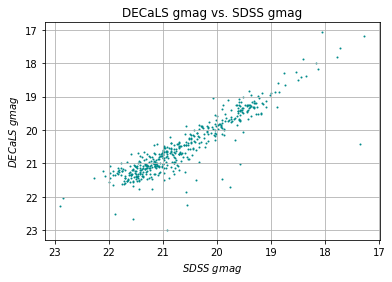

In [109]:
# Plots DECaLS gmag vs SDSS gmag

plt.scatter(sdss_gmag, new_decals_gmag, s = 1, color = 'magenta')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.grid(True)
plt.title('DECaLS gmag vs. SDSS gmag')
plt.xlabel(r'$SDSS$ $gmag$')
plt.ylabel(r'$DECaLS$ $gmag$')

plt.show()

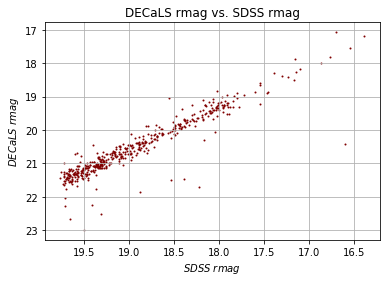

In [111]:
# Plots DECaLS rmag vs SDSS rmag

plt.scatter(cmodel_rmag, new_decals_rmag, s = 1, color = 'maroon')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.grid(True)
plt.title('DECaLS rmag vs. SDSS rmag')
plt.xlabel(r'$SDSS$ $rmag$')
plt.ylabel(r'$DECaLS$ $rmag$')

plt.show()